In [24]:
import pandas as pd
import numpy as np
from scipy.optimize import fmin_bfgs
import networkx as nx
import matplotlib.pyplot as plt

## Разложение Ходжа в задачах ранжирования

In [25]:
file_path = 'C:/Users/artem/OneDrive/Desktop/results.csv'
results_df = pd.read_csv(file_path)
results_df = results_df.dropna()

In [26]:
results_df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
47262,2024-06-11,Saint Kitts and Nevis,Bahamas,1.0,0.0,FIFA World Cup qualification,Basseterre,Saint Kitts and Nevis,False
47263,2024-06-11,Saint Lucia,Aruba,2.0,2.0,FIFA World Cup qualification,Bridgetown,Barbados,True
47264,2024-06-11,Guyana,Belize,3.0,1.0,FIFA World Cup qualification,Bridgetown,Barbados,True
47265,2024-06-11,Dominican Republic,British Virgin Islands,4.0,0.0,FIFA World Cup qualification,San Cristóbal,Dominican Republic,False


In [27]:
results_df['tournament'].value_counts()[:10]

tournament
Friendly                                17971
FIFA World Cup qualification             8169
UEFA Euro qualification                  2824
African Cup of Nations qualification     2116
FIFA World Cup                            964
Copa América                              841
African Cup of Nations                    793
AFC Asian Cup qualification               764
CECAFA Cup                                620
CFU Caribbean Cup qualification           606
Name: count, dtype: int64

Фильтрация по выбранному году и турниру

In [28]:
years = [2014, 2015]  
tournament = "UEFA Euro qualification"  

# Преобразование даты в год
results_df['year'] = pd.to_datetime(results_df['date']).dt.year

# Фильтрация по выбранному году и турниру
filtered_games = results_df[results_df['year'].isin(years)]
if tournament:
    filtered_games = filtered_games[filtered_games['tournament'] == tournament]

teams = pd.concat([filtered_games['home_team'], filtered_games['away_team']]).unique()
teams_df = pd.DataFrame(teams, columns=['team_name'])
teams_df['team_id'] = range(len(teams_df))

filtered_games = filtered_games.merge(teams_df, left_on='home_team', right_on='team_name', how='left').rename(columns={'team_id': 'home_team_id'})
filtered_games = filtered_games.merge(teams_df, left_on='away_team', right_on='team_name', how='left').rename(columns={'team_id': 'away_team_id'})

filtered_games = filtered_games[['date', 'home_team_id', 'away_team_id', 'home_score', 'away_score', 'neutral']]

In [29]:
filtered_games

,date,home_team_id,away_team_id,home_score,away_score,neutral
0,2014-09-07,0,44,2.0,1.0,False
1,2014-09-07,1,45,1.0,3.0,False
2,2014-09-07,2,46,1.0,2.0,False
3,2014-09-07,3,50,2.0,1.0,False
4,2014-09-07,4,48,0.0,7.0,True
...,...,...,...,...,...,...
262,2015-11-14,16,32,2.0,0.0,False
263,2015-11-15,6,24,2.0,1.0,False
264,2015-11-16,46,19,2.0,0.0,False
265,2015-11-17,0,33,2.0,2.0,False


In [30]:
# Функции для ранжирования
def rankGrad(rank_vector):
    return np.subtract.outer(rank_vector, rank_vector).T

def geo_rank(M):
    def rankError(rank_vector):
        return np.sum((M - rankGrad(rank_vector)) ** 2)

    def rankErrorGrad(rank_vector):
        return 2 * (-sum(M - rankGrad(rank_vector)) + sum((M - rankGrad(rank_vector)).T))

    best_x_vec = fmin_bfgs(
        f=rankError,
        x0=np.zeros(shape=(M.shape[0])),
        fprime=rankErrorGrad,
        maxiter=50,
        disp=False
    )
    return best_x_vec

def rankSeason(rs_games, teams, aprioriTop, aprioriStrong, aprioriBad, rerank=[], show_results=False):
    M = np.zeros(shape=(len(teams), len(teams)))
    wins, losses = np.zeros(len(teams)), np.zeros(len(teams))
    
    for i in range(len(rs_games)):
        home_id = rs_games.iloc[i]['home_team_id']
        away_id = rs_games.iloc[i]['away_team_id']
        home_score = rs_games.iloc[i]['home_score']
        away_score = rs_games.iloc[i]['away_score']
        
        if home_score > away_score:
            winner = home_id
            loser = away_id
        else:
            winner = away_id
            loser = home_id
        
        wins[winner] += 1
        losses[loser] += 1
        
        # Эффект затухания
        M[:, [loser, winner]] *= 0.995
        M[[loser, winner], :] *= 0.995
        
        # Корректировка домашнего поля
        hwn_adj = 1 if rs_games.iloc[i]['neutral'] else 0.8
        
        # Применение исхода
        M[loser, winner] += hwn_adj
        M[winner, loser] -= hwn_adj
        
        if i in rerank:
            pwr_scr = geo_rank(M)
            rankInds = np.argsort(-pwr_scr)
            aprioriTop = rankInds[:15]
            aprioriStrong = rankInds[:40]
            aprioriBad = rankInds[150:]
    
    pwr_scr = geo_rank(M)
    pwr_scr = pwr_scr - np.mean(pwr_scr)
    rankInds = np.argsort(-pwr_scr)
    
    if show_results:
        for i in range(min(100, len(teams))):  
            print(f"{i+1}: {teams['team_name'][rankInds[i]]} {pwr_scr[rankInds[i]]:.2f} Record {wins[rankInds[i]]} - {losses[rankInds[i]]}")

    return pwr_scr, rankInds

    
    if show_results:
        for i in range(min(100, len(teams))):  
            print(f"{i+1}: {teams['team_name'][rankInds[i]]} {pwr_scr[rankInds[i]]:.2f} Record {wins[rankInds[i]]} - {losses[rankInds[i]]}")

    return pwr_scr, rankInds

scr, rnk = rankSeason(filtered_games, teams_df, [], [], [], rerank=[10, 20, 30], show_results=True)

ranking = pd.DataFrame({
    'Team': teams_df['team_name'],
    'Power Score': scr
})

# Сортировка по силе команды в порядке убывания
ranking = ranking.iloc[rnk].reset_index(drop=True)

1: England 0.14 Record 10.0 - 0.0
2: Austria 0.12 Record 9.0 - 1.0
3: Spain 0.12 Record 9.0 - 1.0
4: Italy 0.12 Record 9.0 - 1.0
5: Poland 0.09 Record 8.0 - 2.0
6: Portugal 0.09 Record 7.0 - 1.0
7: Ukraine 0.09 Record 9.0 - 3.0
8: Sweden 0.09 Record 9.0 - 3.0
9: Belgium 0.09 Record 8.0 - 2.0
10: Croatia 0.09 Record 8.0 - 2.0
11: Germany 0.06 Record 7.0 - 3.0
12: Republic of Ireland 0.06 Record 8.0 - 4.0
13: Turkey 0.06 Record 7.0 - 3.0
14: Switzerland 0.06 Record 7.0 - 3.0
15: Hungary 0.06 Record 8.0 - 4.0
16: Northern Ireland 0.06 Record 7.0 - 3.0
17: Wales 0.06 Record 7.0 - 3.0
18: Romania 0.06 Record 7.0 - 3.0
19: Czech Republic 0.06 Record 7.0 - 3.0
20: Slovakia 0.06 Record 7.0 - 3.0
21: Russia 0.04 Record 6.0 - 3.0
22: Scotland 0.03 Record 6.0 - 4.0
23: Albania 0.03 Record 5.0 - 3.0
24: Iceland 0.03 Record 6.0 - 4.0
25: Bosnia and Herzegovina 0.00 Record 6.0 - 6.0
26: Norway -0.00 Record 6.0 - 6.0
27: Israel -0.00 Record 5.0 - 5.0
28: Denmark -0.00 Record 5.0 - 5.0
29: Montenegro 

In [31]:
min_score = ranking['Power Score'].min()
max_score = ranking['Power Score'].max()

ranking['Hodge Theoretic Ranking'] = round((ranking['Power Score'] - min_score) / (max_score - min_score) * 100,3)

In [32]:
ranking[['Team','Hodge Theoretic Ranking']].iloc[:10]

,Team,Hodge Theoretic Ranking
0,England,100.000
1,Austria,91.126
2,Spain,90.896
3,Italy,90.713
4,Poland,82.360
5,Portugal,81.796
6,Ukraine,81.465
7,Sweden,81.381
8,Belgium,81.378
9,Croatia,80.954


Граф побед и поражений команд

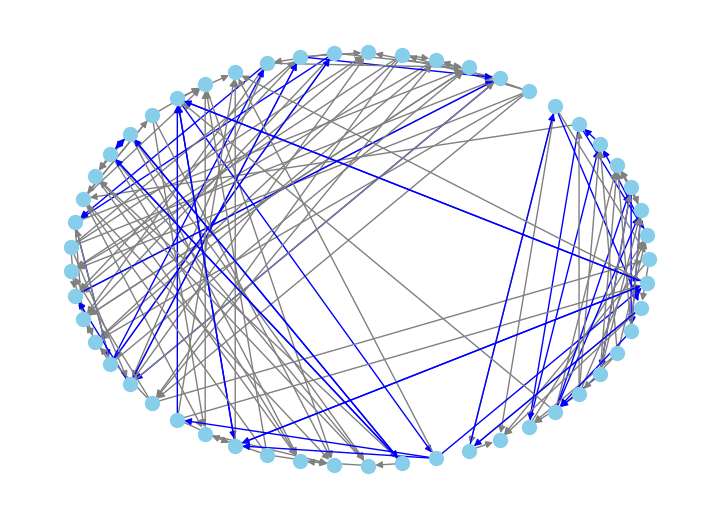

Количество треугольных циклов, где A побеждает B, B побеждает C, и C побеждает A: 17


In [33]:
G = nx.DiGraph()  

for idx, team in teams_df.iterrows():
    G.add_node(team['team_name'])

for i, game in filtered_games.iterrows():
    home_team = teams_df.loc[game['home_team_id'], 'team_name']
    away_team = teams_df.loc[game['away_team_id'], 'team_name']
    if game['home_score'] > game['away_score']:
        G.add_edge(home_team, away_team) 
    elif game['away_score'] > game['home_score']:
        G.add_edge(away_team, home_team)  

triangle_edges = set()
triangle_count = 0

for cycle in nx.simple_cycles(G):
    if len(cycle) == 3:
        a, b, c = cycle
        if G.has_edge(a, b) and G.has_edge(b, c) and G.has_edge(c, a):
            triangle_edges.update([(a, b), (b, c), (c, a)])
            triangle_count += 1

edge_colors = []
for u, v in G.edges():
    if (u, v) in triangle_edges:
        edge_colors.append('blue') 
    else:
        edge_colors.append('gray') 

plt.figure(figsize=(7, 5))
pos = nx.circular_layout(G)  
nx.draw(G, pos, with_labels=False, node_size=100, node_color='skyblue', edge_color=edge_colors, arrows=True)

plt.show()

print(f"Количество треугольных циклов, где A побеждает B, B побеждает C, и C побеждает A: {triangle_count}")